# Modeling coronva virus in Germany

Fit a very simple infection model and compare it to the current numbers of Germany. Added mortality from virus infection.

First run `git clone https://github.com/CSSEGISandData/COVID-19.git && cd COVID-19`

In [1]:
!date

Sa 7. Mär 18:22:28 CET 2020


<div class="alert alert-block alert-info"><b>Note:</b> This uses a very simple model (SIR model) and assumes that no further measures will be taken to curb spread of the virus. The model's infection rate is just fitted visually, the recovery rate is set to 1/21 (3 weeks average).</div>

## imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%pylab inline

from itertools import chain

import numpy as np
from scipy.integrate import odeint
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('seaborn')
FS = 16  # font size

## load current data

In [4]:
!git pull origin master

From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
Already up to date.


In [5]:
df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [6]:
df = df.rename(columns={'Country/Region': 'country'})

In [7]:
df = df.query('country=="Germany"')

In [8]:
df = df.T.tail(-4).reset_index()

In [9]:
df = df.assign(date=pd.to_datetime(df['index']))

In [10]:
df = df.rename(columns={53: 'cases'})

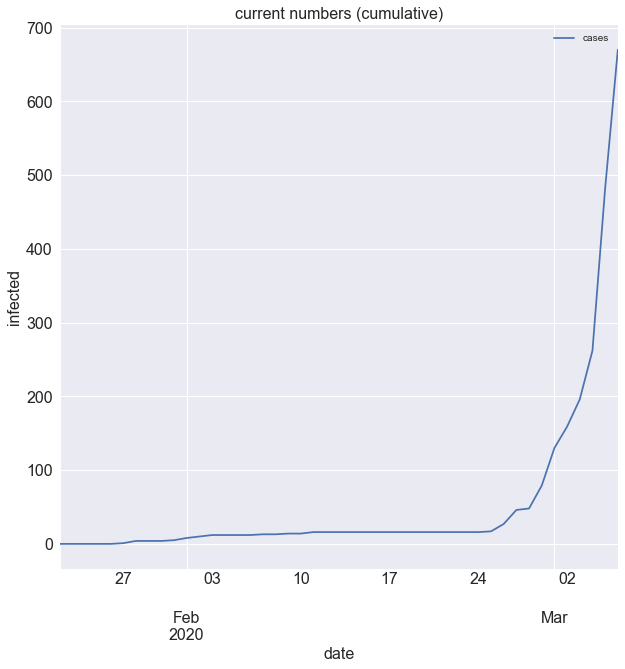

In [11]:
ax = df.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS)
ax.set_xlabel('date', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.set_title('current numbers (cumulative)', fontsize=FS);

## model

Simple SIR model, see: https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease

Model code from here: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [12]:
# Total population, N.
N = 80000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, D0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - D0

# model parameters (in 1/days).
beta = 7 / 21      # infection rate
gamma = 1. / 21    # recovery rate
death = 0.005 / 21  # mortality rate

# A grid of time points (in days)
t = np.arange(200)

In [13]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, death):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + death) * I
    dRdt = gamma * I
    dDdt = death * I
    return dSdt, dIdt, dRdt, dDdt

In [14]:
# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, death))
S, I, R, D = ret.T

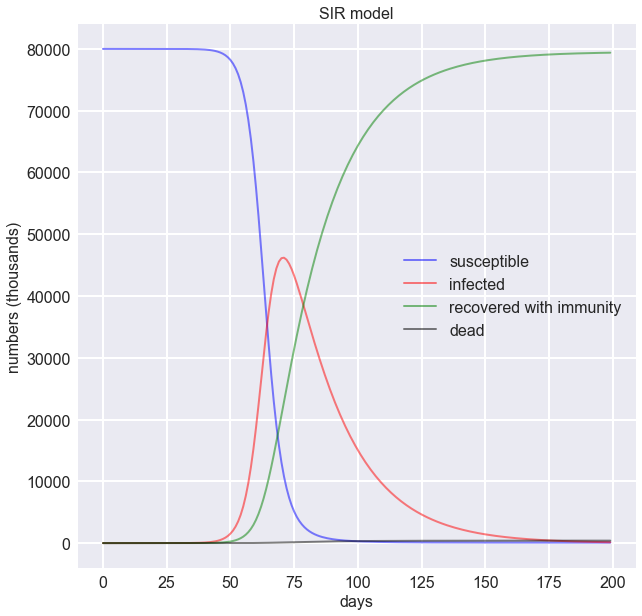

In [15]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='recovered with immunity')
ax.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='dead')
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('numbers (thousands)', fontsize=FS)
ax.set_title('SIR model', fontsize=FS)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize=FS)
legend.get_frame().set_alpha(0.5)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

In [16]:
S[-1], I[-1], R[-1], D[-1]

(76959.99712196787, 137570.21369062195, 79388527.153420329, 396942.63576710137)

## comparison

### "fit" real and model

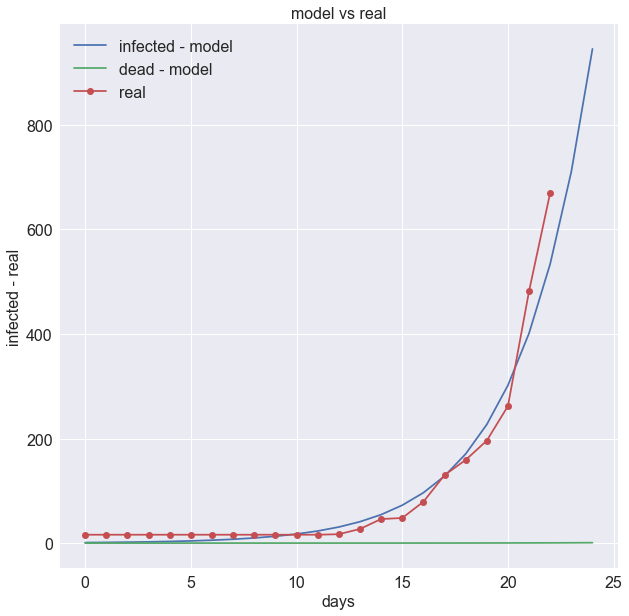

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(I[:25], label='infected - model')
ax.plot(D[:25], label='dead - model')
ax.plot(df['cases'][22:].values, marker='o', label='real')
ax.legend(fontsize=FS)
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('infected - real', fontsize=FS)
ax.set_title('model vs real', fontsize=FS)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

### project numbers

In [18]:
current = df['cases'].values[-1]
print("current number of infected: {}".format(current))

current number of infected: 670


In [19]:
# where are we now in the model?
idx = np.argmin(abs(I - current))

In [20]:
print("maximum number of infected: {}, reached in {} days".format(int(max(I)), np.argmax(I) - idx))

maximum number of infected: 46198481, reached in 48 days


In [21]:
print("total deaths: {}".format(int(D[-1])))

total deaths: 396942


In [22]:
print("21 days projection", end="\n\n")
print("day   infected       dead")
sl = slice(idx - 1, idx + 22)
for i, (infected, dead) in enumerate(zip(I[sl], D[sl]), start=-1):
    print(f" {i:>2} {int(infected): >10} {int(dead): >10}")

21 days projection

day   infected       dead
 -1        534          0
  0        710          0
  1        945          0
  2       1257          1
  3       1672          1
  4       2225          1
  5       2961          2
  6       3939          3
  7       5240          4
  8       6971          5
  9       9275          7
 10      12338         10
 11      16414         13
 12      21835         18
 13      29046         24
 14      38636         32
 15      51391         42
 16      68350         57
 17      90898         75
 18     120868        100
 19     160694        134
 20     213593        178
 21     283822        237


In [24]:
df

,index,cases,date
0,1/22/20,0,2020-01-22
1,1/23/20,0,2020-01-23
2,1/24/20,0,2020-01-24
3,1/25/20,0,2020-01-25
4,1/26/20,0,2020-01-26
5,1/27/20,1,2020-01-27
6,1/28/20,4,2020-01-28
7,1/29/20,4,2020-01-29
8,1/30/20,4,2020-01-30
9,1/31/20,5,2020-01-31
